# Import Packages

In [1]:

import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm

In [2]:
class_names = ['fake fifty', 'fifty original','five hundred fake', 'fivehund original', 'hund fake', 'hundred original', 'ten fake', 'ten original', 'twenty fake', 'twenty original', 'two hund fake', 'two thousand fake',
              'twohund original','twothousand original']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

# Loading the Data


In [3]:
def load_data():

    datasets = [r'C:\Users\TGA\Music\fake currency using gan\seg_train', r'C:\Users\TGA\Music\fake currency using gan\seg_test']

    output = []

    # Iterate through training and test sets
    for dataset in datasets:

        images = []
        labels = []

        print("Loading {}".format(dataset))

        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]

            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')

        output.append((images, labels))

    return output

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading C:\Users\TGA\Music\fake currency using gan\seg_train
















00%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 59.60it/s]

Loading C:\Users\TGA\Music\fake currency using gan\seg_test
















00%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.79it/s]

In [5]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [6]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 83
Number of testing examples: 83
Each image is of size: (150, 150)


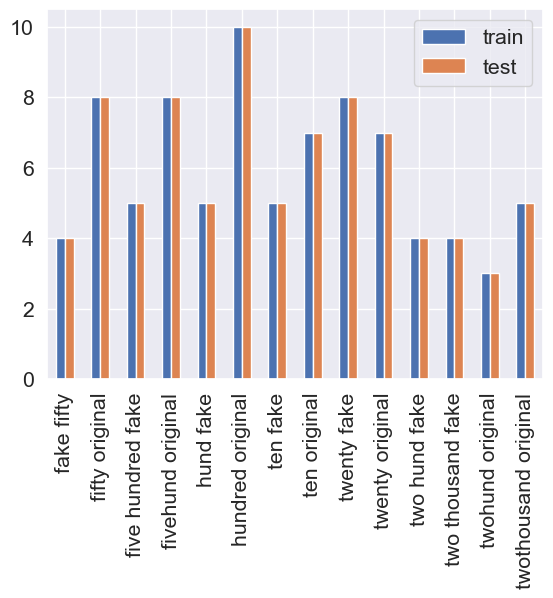

In [7]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts},
             index=class_names
            ).plot.bar()
plt.show()

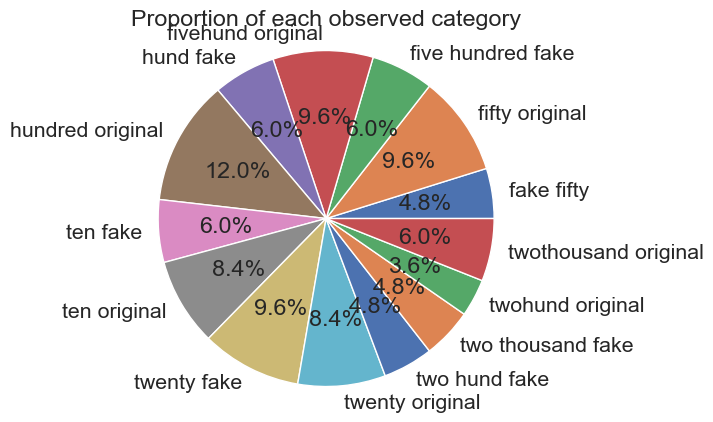

In [9]:
plt.pie(train_counts,
        explode=(0, 0,0,0,0,0,0,0,0,0,0,0,0,0) ,
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [10]:
train_images = train_images / 255.0
test_images = test_images / 255.0

## Visualize the data

In [11]:
def display_random_image(class_names, images, labels):


    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

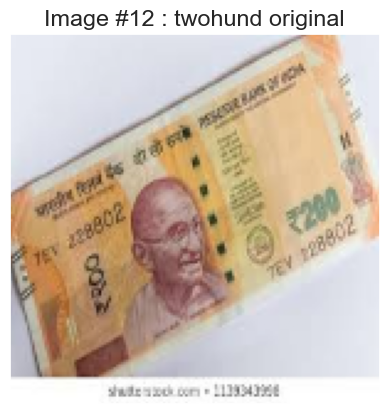

In [12]:
display_random_image(class_names, train_images, train_labels)

In [13]:
def display_examples(class_names, images, labels):
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

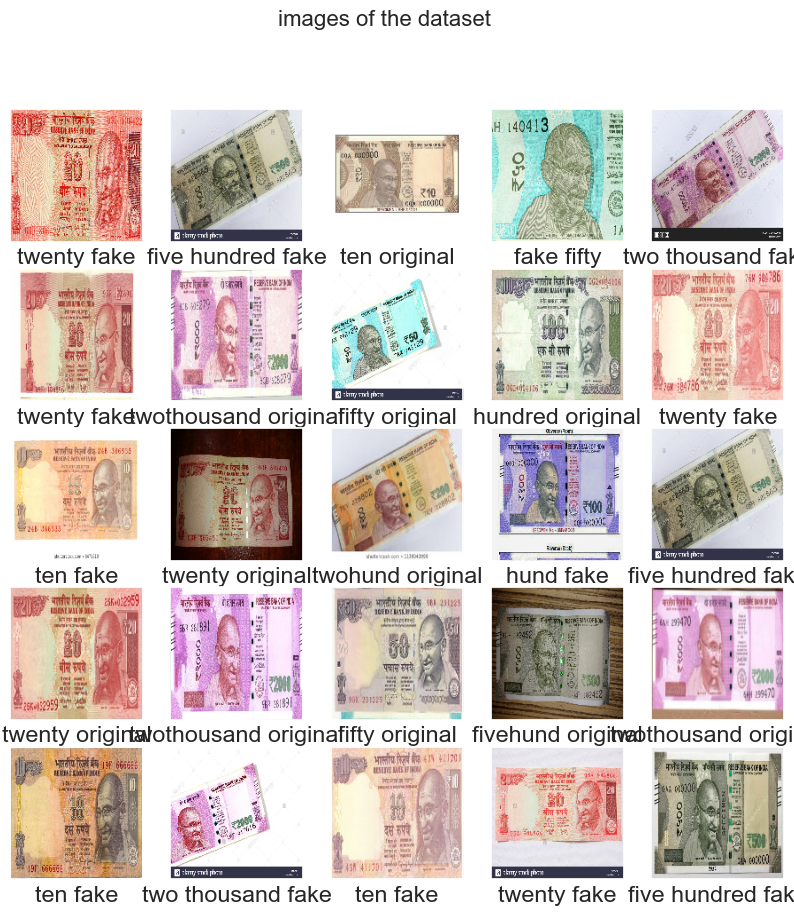

In [14]:
display_examples(class_names, train_images, train_labels)

In [15]:
batch_size =15
epochs = 10
IMG_HEIGHT = 150
IMG_WIDTH = 150


2/2 [==============================] - 1s 46ms/step


0 [D loss: 0.7034355998053792 | D accuracy: 50.0] [G loss: 39.257049560546875]
1/1 [==============================] - 0s 234ms/step


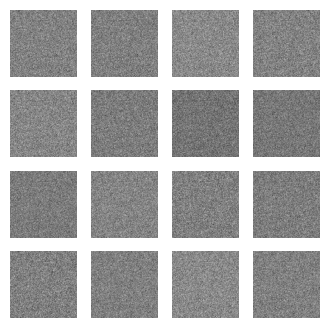



2/2 [==============================] - 0s 60ms/step


In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

# anomaly detection
def build_gan(latent_dim, input_shape):
    input_layer = Input(shape=(latent_dim,))
    x = Dense(128, activation='relu')(input_layer)
    x = Dense(256, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(np.prod(input_shape), activation='sigmoid')(x)
    output_layer = Reshape(input_shape)(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# Define the discriminator model
def build_discriminator(input_shape):
    input_layer = Input(shape=input_shape)
    x = Flatten()(input_layer)
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_layer, outputs=x)
    return model

# Combine the generator and discriminator into a GAN
def build_anomaly_detector(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(latent_dim,))
    generated_image = generator(gan_input)
    gan_output = discriminator(generated_image)
    gan = Model(inputs=gan_input, outputs=gan_output)
    return gan

normal_data = train_images


normal_data = (normal_data.astype(np.float32) - 127.5) / 127.5


np.random.seed(1000)
tf.random.set_seed(1000)
latent_dim = 100
input_shape = normal_data.shape[1:]

generator = build_gan(latent_dim, input_shape)
discriminator = build_discriminator(input_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
generator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

discriminator.trainable = False
gan = build_anomaly_detector(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

epochs = 10
batch_size = 64

for epoch in range(epochs):
    # Select a random batch of normal data
    idx = np.random.randint(0, normal_data.shape[0], batch_size)
    real_images = normal_data[idx]

    # Generate a batch of fake images
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    generated_images = generator.predict(noise)

    # Train the discriminator
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))
    d_loss_real = discriminator.train_on_batch(real_images, real_labels)
    d_loss_fake = discriminator.train_on_batch(generated_images, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train the generator (discriminator weights are frozen)
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    valid_labels = np.ones((batch_size, 1))
    g_loss = gan.train_on_batch(noise, valid_labels)

    # Print progress and save generated images at checkpoints
    if epoch % 100 == 0:
        print(f"{epoch} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

        # Generate and save generated images
        generated_images = generator.predict(np.random.normal(0, 1, (16, latent_dim)))
        generated_images = 0.5 * generated_images + 0.5  # Rescale to [0, 1]
        fig, axs = plt.subplots(4, 4, figsize=(4, 4))
        cnt = 0
        for i in range(4):
            for j in range(4):
                axs[i, j].imshow(generated_images[cnt, :, :, 0], cmap='gray')
                axs[i, j].axis('off')
                cnt += 1
        plt.show()
       
        model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation=tf.nn.relu),
            tf.keras.layers.Dense(14, activation=tf.nn.softmax)
        ])
        model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])


In [17]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=10, validation_split = 0.2)

Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 2.6541 - accuracy: 0.0909 - val_loss: 5.5034 - val_accuracy: 0.1176
Epoch 2/10
1/1 [==============================] - 1s 848ms/step - loss: 4.1021 - accuracy: 0.1212 - val_loss: 4.9303 - val_accuracy: 0.0588
Epoch 3/10
1/1 [==============================] - 1s 988ms/step - loss: 3.7107 - accuracy: 0.1515 - val_loss: 3.7875 - val_accuracy: 0.0588
Epoch 4/10
1/1 [==============================] - 1s 896ms/step - loss: 3.0650 - accuracy: 0.1515 - val_loss: 3.2605 - val_accuracy: 0.0588
Epoch 5/10
1/1 [==============================] - 1s 882ms/step - loss: 2.7591 - accuracy: 0.1364 - val_loss: 2.8614 - val_accuracy: 0.1176
Epoch 6/10
1/1 [==============================] - 1s 832ms/step - loss: 2.4593 - accuracy: 0.1818 - val_loss: 2.6348 - val_accuracy: 0.1176
Epoch 7/10
1/1 [==============================] - 1s 814ms/step - loss: 2.2515 - accuracy: 0.2121 - val_loss: 2.5341 - val_accuracy: 0.1176
Epoch 8/10
1/1 [=======

In [18]:
def plot_accuracy_loss(history):

    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_accuracy")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

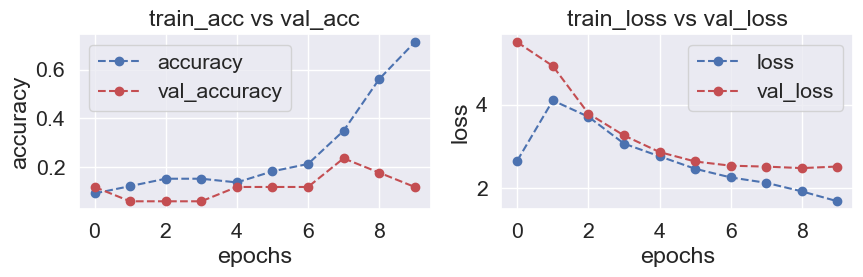

In [19]:
plot_accuracy_loss(history)

In [20]:
test_loss = model.evaluate(test_images, test_labels)

3/3 [==============================] - 0s 74ms/step - loss: 1.6830 - accuracy: 0.5904


3/3 [==============================] - 0s 78ms/step


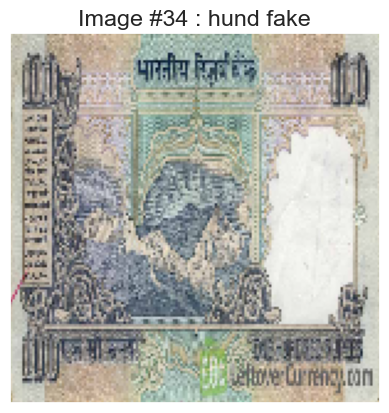

In [21]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_images, pred_labels)

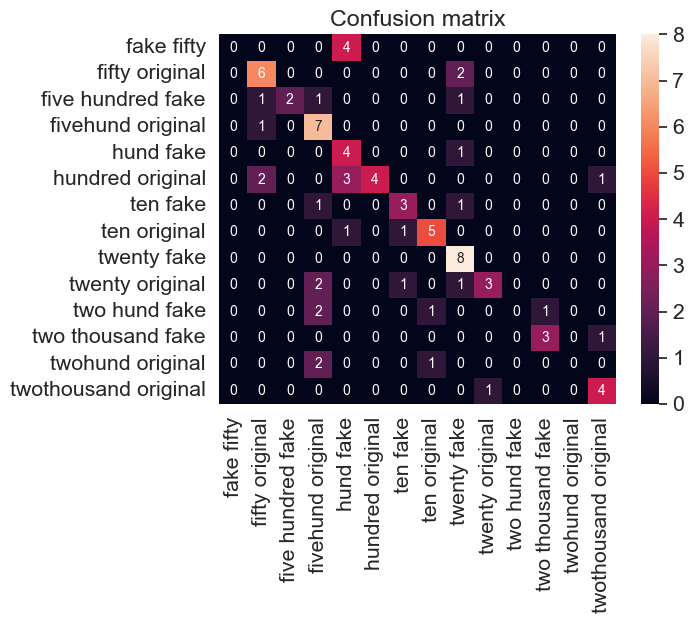

In [22]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True,
           annot_kws={"size": 10},
           xticklabels=class_names,
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming y_true contains true labels and y_pred contains predicted labels
y_true = [0, 1, 0, 1]
y_pred = [0, 1, 1, 1]

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_true, y_pred)
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_true, y_pred)
print("Recall:", recall)

# Calculate F1 score
f1 = f1_score(y_true, y_pred)
print("F1 Score:", f1)

Accuracy: 0.75
Precision: 0.6666666666666666
Recall: 1.0
F1 Score: 0.8


In [24]:
from sklearn.metrics import classification_report
print("\n Classification report : \n {}".format(classification_report(test_labels, pred_labels)))


 Classification report : 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.60      0.75      0.67         8
           2       1.00      0.40      0.57         5
           3       0.47      0.88      0.61         8
           4       0.33      0.80      0.47         5
           5       1.00      0.40      0.57        10
           6       0.60      0.60      0.60         5
           7       0.71      0.71      0.71         7
           8       0.57      1.00      0.73         8
           9       0.75      0.43      0.55         7
          10       0.00      0.00      0.00         4
          11       0.75      0.75      0.75         4
          12       0.00      0.00      0.00         3
          13       0.67      0.80      0.73         5

    accuracy                           0.59        83
   macro avg       0.53      0.54      0.50        83
weighted avg       0.59      0.59      0.55        8

C:\Users\TGA\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\TGA\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\TGA\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

C:\Users\TGA\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\TGA\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\TGA\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

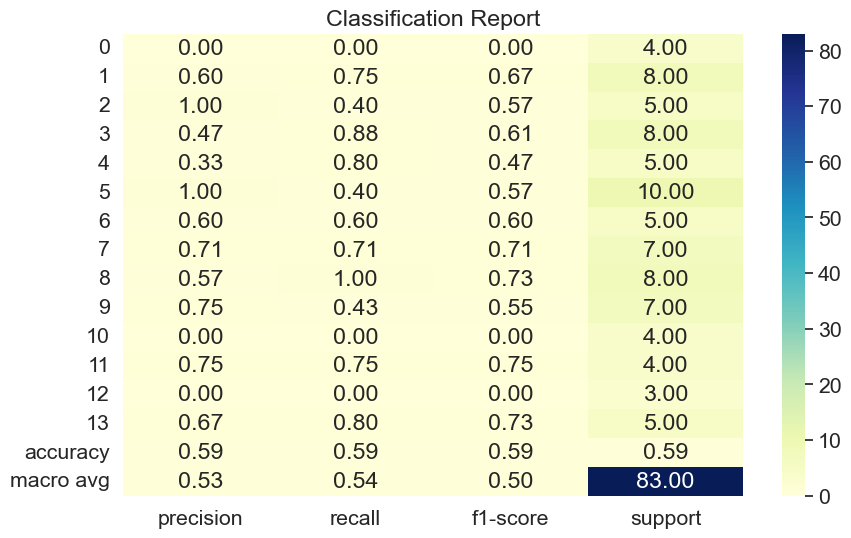

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Assuming test_labels and pred_labels are available

# Generate classification report
report = classification_report(test_labels, pred_labels, output_dict=True)

# Convert the classification report to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :].astype(float), annot=True, cmap="YlGnBu", fmt=".2f")
plt.title('Classification Report')
plt.show()

In [26]:
model.save_weights("model_vgg.weights.h5")
print("Saved model to disk")

Saved model to disk


In [27]:
model_json=model.to_json()
with open("model_vgg.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog
import numpy as np
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog
import numpy as np
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import tensorflow as tf
from flask import Flask, render_template, request, send_from_directory

app = Flask(__name__)
UPLOAD_FOLDER = "uploads"
STATIC_FOLDER = "static"

json_file = open('model_vgg.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
#cnn_model = model_from_json(loaded_model_json)
# load weights into new model
#cnn_model.load_weights("model_vgg.weights.h5")
# Load model

IMAGE_SIZE = 150

# Preprocess an image
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image /= 255.0  # normalize to [0,1] range
    return image

# Read the image from path and preprocess
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

# Predict & classify image
def classify(model, image_path):
    preprocessed_image = load_and_preprocess_image(image_path)
    preprocessed_image = tf.reshape(preprocessed_image, (1, IMAGE_SIZE, IMAGE_SIZE, 3))
    prob = model.predict(preprocessed_image)[0]
    print(prob)
    # Get the index of the maximum probability
    predicted_label_index = np.argmax(prob)
    # Mapping index to label name
    label_names = ['fake fifty', 'fifty original','five hundred fake', 'fivehund original', 'hund fake', 'hundred original', 'ten fake', 'ten original', 'twenty fake', 'twenty original', 'two hund fake', 'two thousand fake',
              'twohund original','twothousand original']
    # Replace with your actual label names
    label = label_names[predicted_label_index]
    classified_prob = prob[predicted_label_index]
    return label, classified_prob

# home page
@app.route("/")
def home():
    return render_template("home.html")

@app.route("/classify", methods=["POST", "GET"])
def upload_file():
    if request.method == "GET":
        return render_template("home.html")
    else:
        file = request.files["image"]
        upload_image_path = os.path.join(UPLOAD_FOLDER, file.filename)
        print(upload_image_path)
        file.save(upload_image_path)
        label, prob = classify(model, upload_image_path)
        prob = round((prob * 100), 2)
    return render_template(
        "classify.html", image_file_name=file.filename, label=label, prob=prob
    )

@app.route("/classify/<filename>")
def send_file(filename):
    return send_from_directory(UPLOAD_FOLDER, filename)

if __name__ == "__main__":
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [13/Jan/2025 14:11:35] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [13/Jan/2025 14:11:35] "GET /static/images/download.jpg HTTP/1.1" 200 -
127.0.0.1 - - [13/Jan/2025 14:11:35] "GET /static/script.js HTTP/1.1" 304 -
127.0.0.1 - - [13/Jan/2025 14:11:35] "GET /static/images/bg.jpg HTTP/1.1" 200 -
